<a href="https://colab.research.google.com/github/sujithkumarpagolu/credit-card--transactions/blob/main/Copy_of_Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score
from mpl_toolkits.mplot3d import Axes3D  # For 3D plots
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
df = pd.read_csv('/fraudTrain.csv')
t_df = pd.read_csv('/fraudTest.csv')
df

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1.325376e+09,36.011293,-82.048315,0.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1.325376e+09,49.159047,-118.186462,0.0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1.325376e+09,43.150704,-112.154481,0.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1.325376e+09,47.034331,-112.561071,0.0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1.325376e+09,38.674999,-78.632459,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11701,11701,2019-01-07 20:38:04,4223708906367574214,fraud_Reichert-Weissnat,travel,542.06,Adam,Riddle,M,27718 Mason Bypass,...,39.0965,-84.6431,177,Exhibition designer,1974-05-30,107e3c2b46ef9ce28185427a45fa2088,1.325969e+09,38.219354,-83.672260,0.0
11702,11702,2019-01-07 20:38:05,3541160328600277,"fraud_O'Reilly, Mohr and Purdy",home,42.50,Jason,Singh,M,4720 Anna Ways,...,39.5723,-90.2379,1512,Commercial/residential surveyor,2003-05-07,3f9554d76d89abb2d47e34f9da025159,1.325969e+09,40.564579,-90.378169,0.0
11703,11703,2019-01-07 20:39:07,6011438889172900,fraud_Mohr-Bayer,shopping_net,21.42,Allison,Allen,F,40624 Rebecca Spurs,...,34.2853,-91.3336,5161,Electrical engineer,1993-04-08,fa72d8dfc5aae27396428ab33aeb60cb,1.325969e+09,33.644988,-91.317119,0.0
11704,11704,2019-01-07 20:39:27,4509922033272157,fraud_Grimes LLC,entertainment,114.74,Monica,West,F,22084 Smith Roads Suite 776,...,43.2893,-97.1904,811,Neurosurgeon,1972-03-28,372455d5c962a18f36d82664af9e0747,1.325969e+09,43.400960,-96.594169,0.0


In [ ]:
df['is_fraud'].value_counts()

,count
is_fraud,
0.0,11657
1.0,48


In [ ]:
def preprocess_data(df):
    # Drop unnecessary columns
    df = df.drop(['cc_num', 'trans_date_trans_time', 'first', 'last', 'dob', 'street', 'trans_num', 'unix_time', 'merchant'], axis=1)

    # Handle outliers for 'amt' and 'city_pop'
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numerical_columns:
        if col in ['amt', 'city_pop']:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

    # Encode categorical variables
    label_encoder = LabelEncoder()
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_columns:
      df[col] = label_encoder.fit_transform(df[col])

    # Convert gender to binary
    df['gender'] = df['gender'].apply(lambda x: 1 if x == 'M' else 0)

    # Normalize numerical features
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    return df_scaled

In [ ]:
df_preprocessed = preprocess_data(df)
t_df_preprocessed = preprocess_data(t_df)

print(df_preprocessed.head())
print(t_df_preprocessed.head())

   Unnamed: 0  category       amt  gender      city     state       zip  \
0    0.000000  0.615385  0.020607     0.0  0.592548  0.530612  0.278069   
1    0.000085  0.307692  0.552736     0.0  0.681490  0.938776  0.993677   
2    0.000171  0.000000  1.000000     0.0  0.527644  0.244898  0.832217   
3    0.000256  0.153846  0.228910     0.0  0.097356  0.510204  0.592483   
4    0.000342  0.692308  0.213091     0.0  0.243990  0.897959  0.235227   

        lat      long  city_pop       job  merch_lat  merch_long  is_fraud  
0  0.351527  0.864638  0.073276  0.749474   0.354796    0.848563       0.0  
1  0.632040  0.485682  0.002659  0.865263   0.631711    0.485668       0.0  
2  0.485159  0.546553  0.087184  0.618947   0.505164    0.546241       0.0  
3  0.573848  0.548070  0.040437  0.663158   0.586961    0.542158       0.0  
4  0.402814  0.882190  0.001604  0.231579   0.410898    0.882864       0.0  
   Unnamed: 0  category       amt  gender      city     state       zip  \
0    0.00000

In [ ]:
df_preprocessed.isna().sum()

,0
Unnamed: 0,0
category,0
amt,0
gender,0
city,0
state,0
zip,0
lat,0
long,0
city_pop,0


In [ ]:
# check coulmns type and missing values and shape of data
df_preprocessed.info()
# this mean nulls = zero
# we need to convert any object to numrical value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11706 entries, 0 to 11705
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  11706 non-null  float64
 1   category    11706 non-null  float64
 2   amt         11706 non-null  float64
 3   gender      11706 non-null  float64
 4   city        11706 non-null  float64
 5   state       11706 non-null  float64
 6   zip         11706 non-null  float64
 7   lat         11706 non-null  float64
 8   long        11706 non-null  float64
 9   city_pop    11706 non-null  float64
 10  job         11706 non-null  float64
 11  merch_lat   11705 non-null  float64
 12  merch_long  11705 non-null  float64
 13  is_fraud    11705 non-null  float64
dtypes: float64(14)
memory usage: 1.3 MB


In [ ]:
# get statistics on numrical columns ( int or float )
df_preprocessed.describe()

,Unnamed: 0,category,amt,gender,city,state,zip,lat,long,city_pop,job,merch_lat,merch_long,is_fraud
count,11706.000000,11706.000000,11706.000000,11706.0,11706.000000,11706.000000,11706.000000,11706.000000,11706.000000,11706.000000,11706.000000,11705.000000,11705.000000,11705.000000
mean,0.500000,0.476843,0.296584,0.0,0.498412,0.522818,0.486727,0.405910,0.768827,0.273296,0.506578,0.408492,0.763336,0.004101
std,0.288712,0.299719,0.274691,0.0,0.290348,0.289888,0.275057,0.113301,0.146880,0.385414,0.286045,0.109521,0.144353,0.063909
min,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.230769,0.045480,0.0,0.243990,0.285714,0.251548,0.322289,0.702108,0.015195,0.261053,0.329939,0.696801,0.000000
50%,0.500000,0.461538,0.247097,0.0,0.494591,0.530612,0.478869,0.423638,0.798469,0.050335,0.501053,0.425341,0.792489,0.000000
75%,0.750000,0.769231,0.427288,0.0,0.756010,0.755102,0.719688,0.477842,0.875077,0.409117,0.760000,0.478754,0.866854,0.000000
max,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
print(df_preprocessed.duplicated().sum())

0


In [ ]:
df_preprocessed.dtypes

,0
Unnamed: 0,float64
category,float64
amt,float64
gender,float64
city,float64
state,float64
zip,float64
lat,float64
long,float64
city_pop,float64


In [ ]:
X_train = df_preprocessed.drop('is_fraud', axis=1)
y_train = df_preprocessed['is_fraud']
X_test = t_df_preprocessed.drop('is_fraud', axis=1)
y_test = t_df_preprocessed['is_fraud']

<ipython-input-13-4a29ec2fbeda>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='is_fraud', y='amt', data=df_preprocessed, palette='coolwarm')


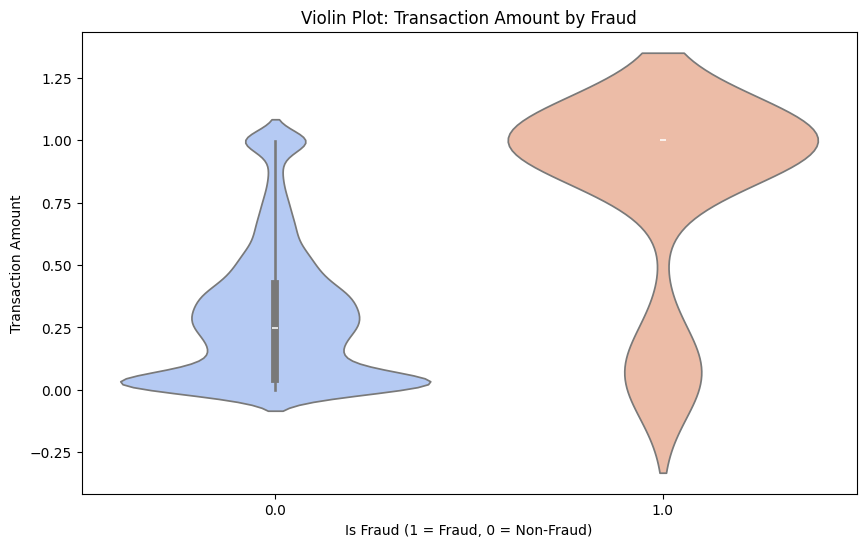

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='is_fraud', y='amt', data=df_preprocessed, palette='coolwarm')
plt.title('Violin Plot: Transaction Amount by Fraud')
plt.xlabel('Is Fraud (1 = Fraud, 0 = Non-Fraud)')
plt.ylabel('Transaction Amount')
plt.show()

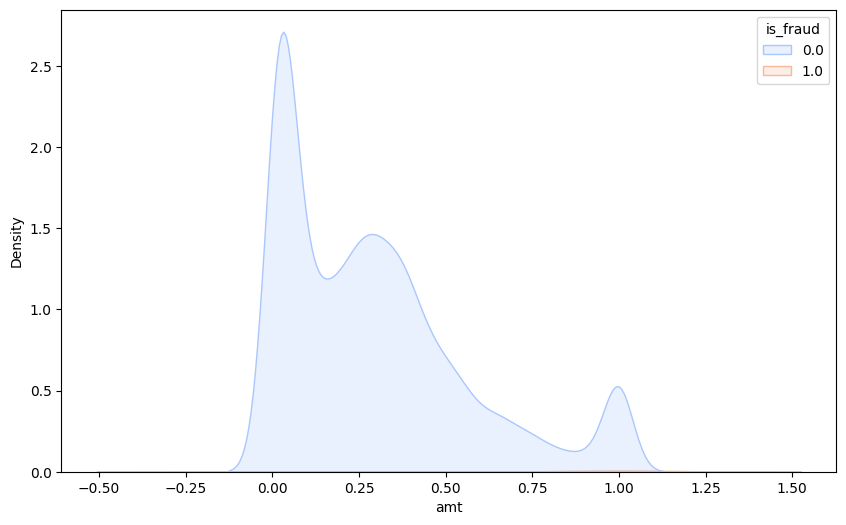

In [ ]:
# KDE Plot with Clear Labels
plt.figure(figsize=(10, 6))
kde_plot = sns.kdeplot(data=df_preprocessed,
                       x='amt',
                       hue='is_fraud',
                       palette='coolwarm',
                       fill=True)

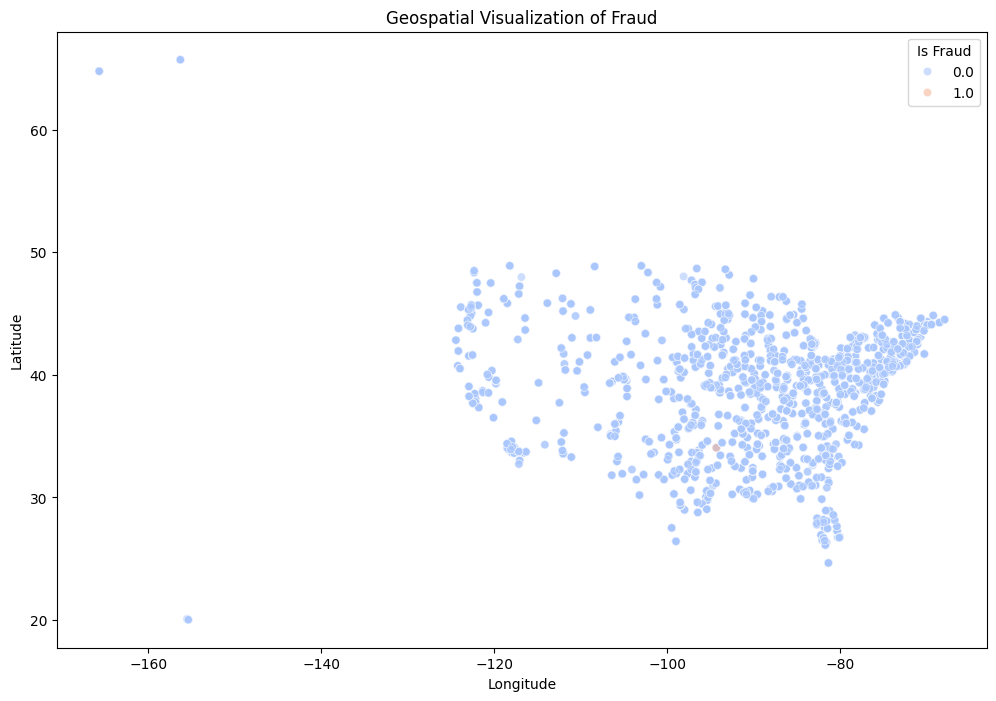

In [ ]:
# Plot fraud incidents on a map
plt.figure(figsize=(12, 8))
sns.scatterplot(x='long', y='lat', hue='is_fraud', data=df, palette='coolwarm', alpha=0.6)
plt.title('Geospatial Visualization of Fraud')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Is Fraud', loc='upper right')
plt.show()

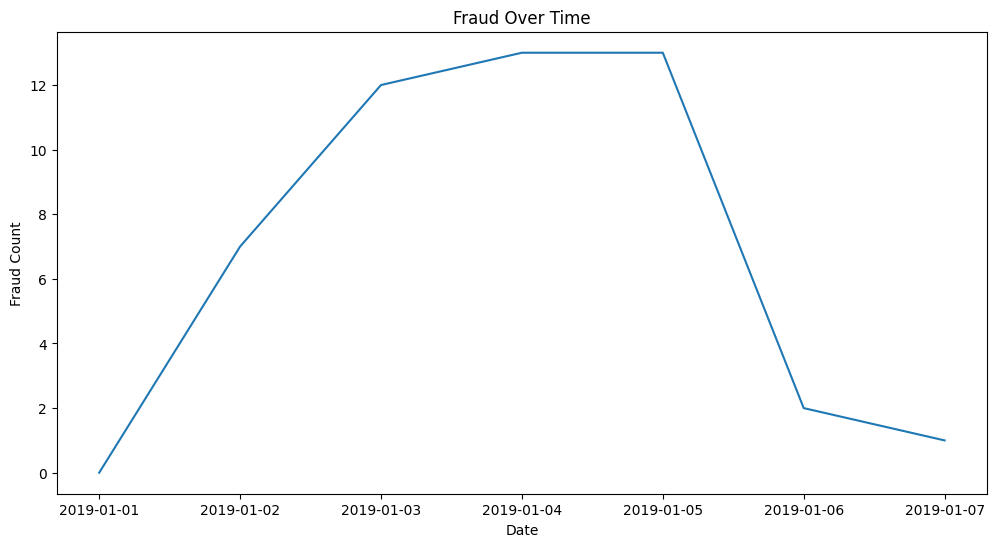

In [ ]:
# Convert transaction time to datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

# Group by date and calculate fraud count
fraud_over_time = df.groupby(df['trans_date_trans_time'].dt.date)['is_fraud'].sum()

# Plot time series
plt.figure(figsize=(12, 6))
fraud_over_time.plot()
plt.title('Fraud Over Time')
plt.xlabel('Date')
plt.ylabel('Fraud Count')
plt.show()

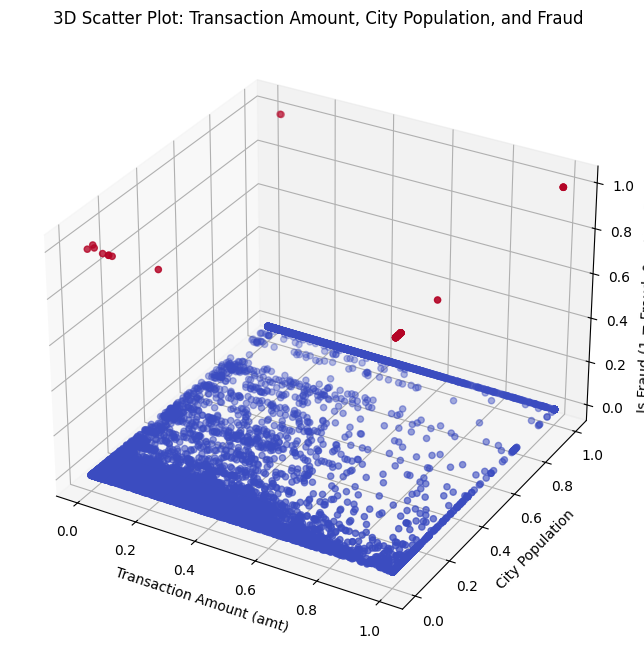

In [ ]:
# 7. 3D Scatter Plot: Transaction Amount, City Population, and Fraud
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    df_preprocessed['amt'],
    df_preprocessed['city_pop'],
    df_preprocessed['is_fraud'],
    c=df_preprocessed['is_fraud'],
    cmap='coolwarm',
    s=20
)

# Labels
ax.set_xlabel('Transaction Amount (amt)')
ax.set_ylabel('City Population')
ax.set_zlabel('Is Fraud (1 = Fraud, 0 = Non-Fraud)')
plt.title('3D Scatter Plot: Transaction Amount, City Population, and Fraud')
plt.show()

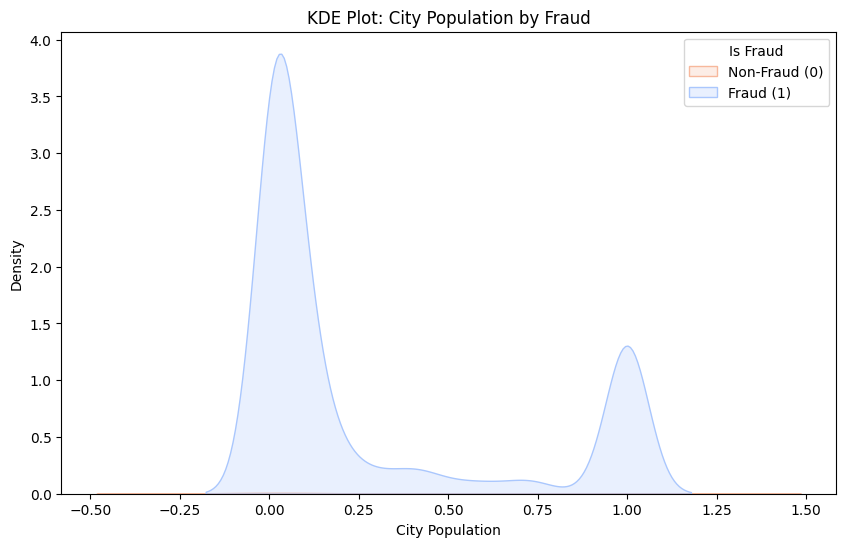

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_preprocessed, x='city_pop', hue='is_fraud', palette='coolwarm', fill=True)
plt.title('KDE Plot: City Population by Fraud')
plt.xlabel('City Population')
plt.ylabel('Density')
plt.legend(title='Is Fraud', labels=['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

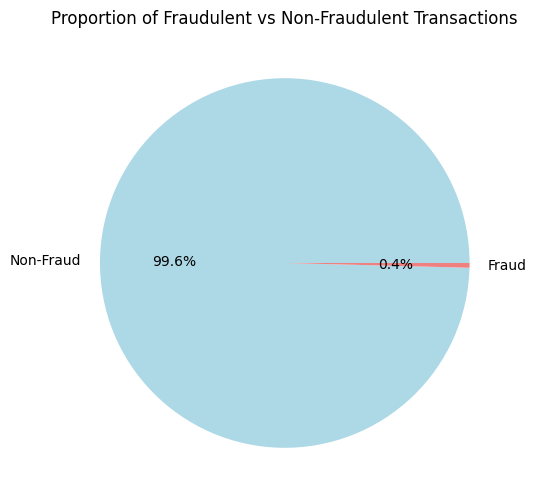

In [ ]:
# Calculate fraud proportion
fraud_proportion = df['is_fraud'].value_counts(normalize=True)

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(fraud_proportion, labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Proportion of Fraudulent vs Non-Fraudulent Transactions')
plt.show()

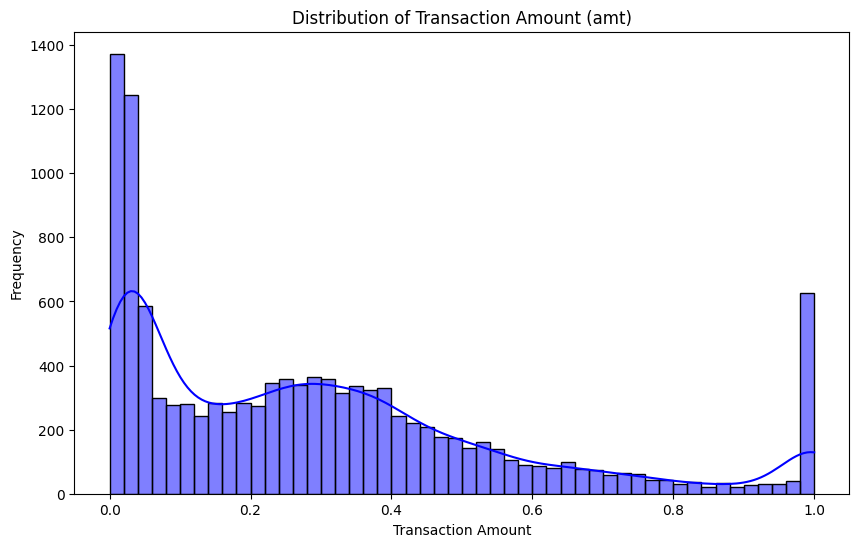

In [ ]:
# Distribution of Transaction Amount (amt)
plt.figure(figsize=(10, 6))
sns.histplot(df_preprocessed['amt'], bins=50, kde=True, color='blue')
plt.title('Distribution of Transaction Amount (amt)')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

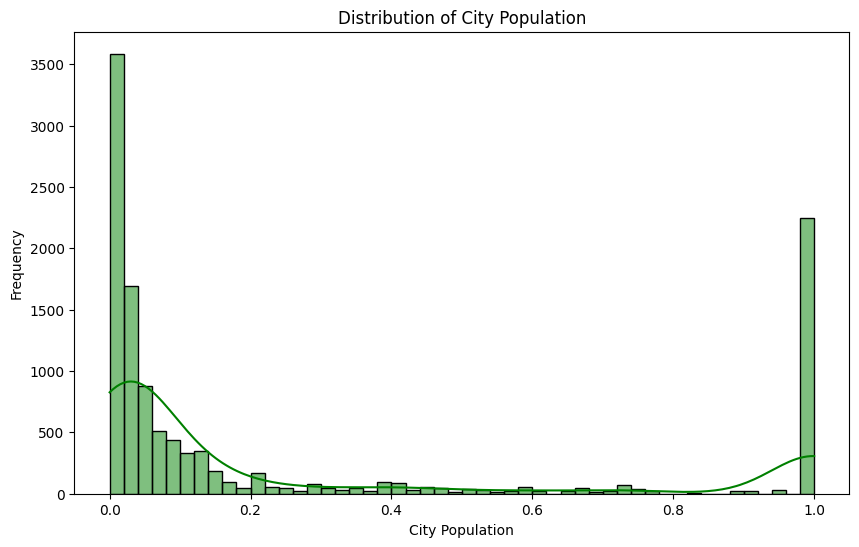

In [ ]:
# Distribution of City Population
plt.figure(figsize=(10, 6))
sns.histplot(df_preprocessed['city_pop'], bins=50, kde=True, color='green')
plt.title('Distribution of City Population')
plt.xlabel('City Population')
plt.ylabel('Frequency')
plt.show()

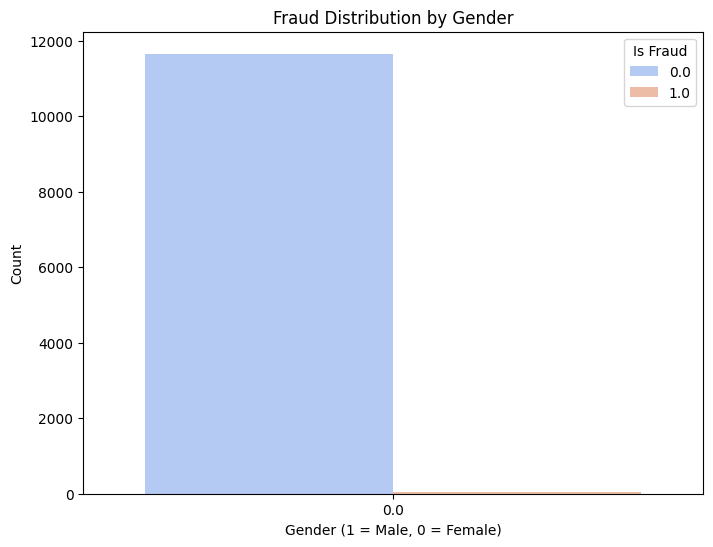

In [ ]:
# Fraud Distribution by Gender
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', hue='is_fraud', data=df_preprocessed, palette='coolwarm')
plt.title('Fraud Distribution by Gender')
plt.xlabel('Gender (1 = Male, 0 = Female)')
plt.ylabel('Count')
plt.legend(title='Is Fraud', loc='upper right')
plt.show()

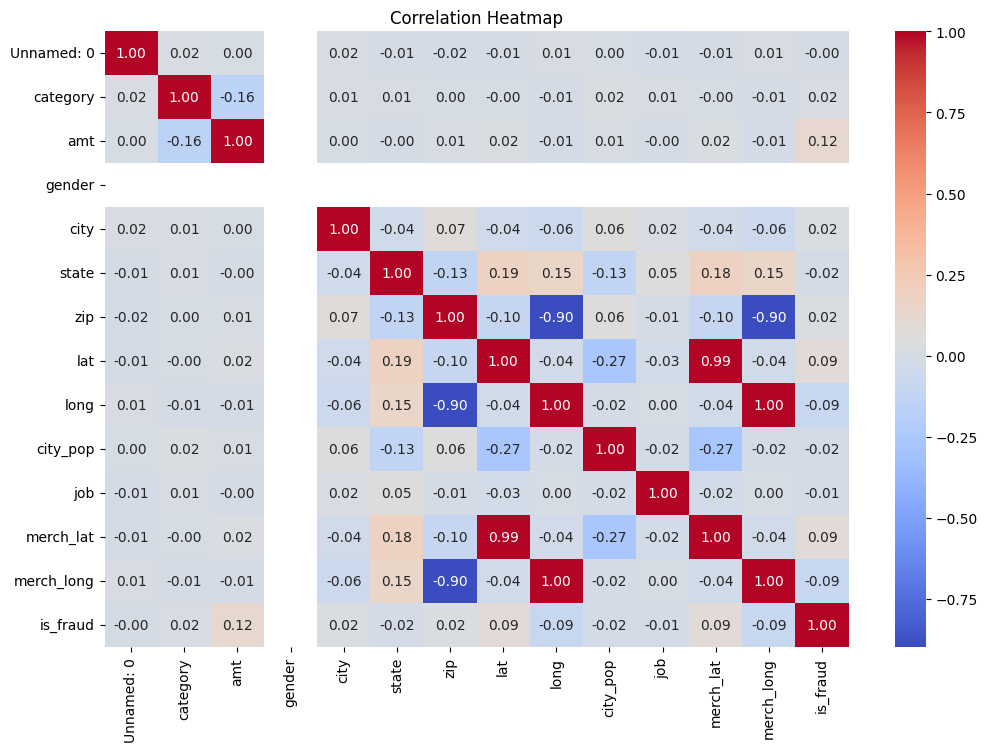

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
corr = df_preprocessed.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()